## Impact of a negative externality on the society welfare and the optimal taxation combination (Ramsey)
----------------------------------------------------------------

In [1]:
import numpy as np ; from sympy import * ; import scipy.optimize as opt ; import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

This code is part of the Group 8 assignment for the EBA 3650 Quantitative Economics subject (Spring 2022).<br>
<br>
This work assumes a world where there is a group of customers and two suppliers, Firm 1 and 2 which will each produce good 1 or good 2. A government is present and will influence the model by deciding how much tax revenue it wishes to collect. <br>
We assume at first that this world does not undergo any negative externalities. Using general equilibrium theory and Walras' laws, we will use a solver to calculate the optimal quantities of consumption, units of labor offered by customers and the prices of products. Using these data the model will apply a root finding algorithm, in order to solve the following equation: $$ (c_1 \cdot t_1 + c_2 \cdot t_2) - tax\, target\, revenue = 0$$ The code will find the tax rates for product 1 and 2 which will return the tax revenue desired by the government. Then, using tax, labor and consumption information, the welfare of society will be graphically illustrated to find which tax combination has the greatest positive effect on society. <br>
Secondly, the model presupposes an externality generated by company 1 which will negatively affect consumers. In this assignment, it is assumed that at the level of each individual this externality does not influence their consumption decision. Instead, the externality is felt by society through the welfare function. 
$$ w(c_1,c_2,m) = \frac{1}{1+\frac{1}{e_1}}c_1^{1+\frac{1}{e_1}} \cdot \frac{1}{1+\frac{1}{e_2}}c_2^{1+\frac{1}{e_2}} -m - C_1 $$
<br>

The assignment will therefore show the variations in welfare of society and how the optimal tax combination changes due to the presence of an externality.

### Model Creation

In [2]:
# Here is the class that contains all the functions that will be used in the code
class Tax_Externality:
    def __init__(self, e1, e2, k1, k2, n, target_taxes):

        self.e1 = e1 # Demand sensibility
        self.e2 = e2 # Demand sensibility
        self.k1 = k1 # Capital available for firm 1
        self.k2 = k2 # Capital available for firm 2
        self.alpha = 0.3 # Production sensibility
        self.n = n # Number of consumers
        self.target_taxes = target_taxes # Tax revenues wanted by the governement

        return

    # General equilibrium, with taxes as parameters
    def ge_variable_taxes(self, to_be_found, t1,t2):
        c1, c2, m1, m2, p1, p2 = to_be_found ; output = np.zeros(6)

        #FOC For demand : (ua)' - (consa)' = 0 ie partial derivatives w/ respect a (and b in second case)
        x, y = symbols("x,y") # 2 parameters for the partial derivatives
        f = 1/(1+(1/self.e1))*x**(1+(1/self.e1)) + 1/(1+(1/self.e2))*y**(1+(1/self.e2)) #utility
        cons = (p1 + t1)*x + (p2 + t2)*y #constraint
        uc1 = diff(f,x) ; uc2 = diff(f,y) # Partial derivative of the utility
        cons1 = diff(cons,x) ; cons2 = diff(cons,y) # Partial derivatives of the constraint

        fOCc1=lambdify([x,y],uc1 - cons1, "numpy") # Transfom the derivative into a function for demand1
        fOCc2=lambdify([x,y],uc2 - cons2, "numpy") # Transfom the derivative into a function for demand2

        output[0]=fOCc1(c1,c2) #demand/consumption c1
        output[1]=fOCc2(c1,c2) #demand/consumption c2

        #FOC For supply : pi * (k)^alpha * (m)^(1-alpha) - 1 ie partial derivative w/ respect to m
        x, y = symbols("x,y") # 2 parameters for the partial derivatives
        prod1 = p1 * np.power(self.k1,self.alpha) * np.power(x,1-self.alpha) - x # p * production - work
        prod2 = p2 * np.power(self.k2,self.alpha) * np.power(y,1-self.alpha) - y # p * production - work
        
        dprod1 = diff(prod1,x) ; dprod2 = diff(prod2,y) # Partial derivatives for the production function
        
        fOCprod1 = lambdify([x],dprod1, "numpy")
        fOCprod2 = lambdify([y],dprod2, "numpy")

        output[2]=fOCprod1(m1) #supply 1 foc : quantity of work offered in firm 1
        output[3]=fOCprod2(m2) #supply 2 foc : quantity of work offered in firm 2
        
        # Walras' Laws
        #Market Clearance condition : consumption - production = 0
        output[4]=c1 - np.power(self.k1, self.alpha) * np.power(m1, 1-self.alpha) 
        output[5]=c2 - np.power(self.k2, self.alpha) * np.power(m2, 1-self.alpha) 
        return output

    # Tax Revenue - Tax Target Revenue with tax rates as parameters
    def tax_revenue_variable_taxes(self,t2,t1):
        results = opt.root(self.ge_variable_taxes,np.ones(6), args = (t1,t2)).x
        c1,c2,m1,m2,p1,p2 = results
        return t1*c1 + t2*c2-self.target_taxes
    
    # Optimize the tax, for a given list of tax 1, find the corresponding tax 2, compute outputs and welfare 
    def tax_schedule(self, list_t1, externality):
        list_t2 = np.zeros(self.n) ; list_welfare = np.zeros(self.n) ; list_outputs_wo_e = [] ; list_outputs_w_e = []
        list_welfare_we = np.zeros(self.n)

        # Externality should be given by 1 (if yes), or 0 (if no), all other values should return an error
        if (externality != 0 and externality != 1):
            print("Select if externality : 0 = No, 1 = Yes")
        else:
            
            #If there is externality add the externality to the welfare
            if externality == 1:
                for i in range(self.n): 
                    #For each value of tax 1 find a value for tax 2 so that tax revenue - target = 0
                    list_t2[i] = opt.bisect(self.tax_revenue_variable_taxes,-1,1.2,args=(list_t1[i],))
                    #Using tax 1 and tax 2 computes consumption, work, prices and compute welfare
                    res2 = opt.root(self.ge_variable_taxes, np.ones(6), args = (list_t1[i], list_t2[i])).x
                    list_outputs_w_e.append(res2)
                    c1e,c2e,m1e,m2e,p1e,p2e = res2
                    list_welfare_we[i] = 1/(1+(1/self.e1))*np.power(c1e,(1+(1/self.e1))) + 1/(1+(1/self.e2))*np.power(c2e,(1+(1/self.e2))) - (m1e + m2e) - c1e# utility
                return list_t2, list_welfare_we, list_outputs_w_e
            
            # If there is no externality return the simple welfare
            elif externality == 0:
                for i in range(self.n): 
                    #For each value of tax 1 optimize a value for tax 2
                    list_t2[i] = opt.bisect(self.tax_revenue_variable_taxes,-1,1.2,args=(list_t1[i],))

                    #Optimize the consumption, work and prices using the taxes and utility
                    res = opt.root(self.ge_variable_taxes, np.ones(6), args = (list_t1[i], list_t2[i])).x
                    c1,c2,m1,m2,p1,p2 = res
                    list_outputs_wo_e.append(res)
                    #Compute the general welfare function
                    list_welfare[i] = 1/(1+(1/self.e1))*np.power(c1,(1+(1/self.e1))) + 1/(1+(1/self.e2))*np.power(c2,(1+(1/self.e2))) - (m1 + m2)# utility
                return list_t2, list_welfare, list_outputs_wo_e
    
    # Create a function to separate the outputs 
    def divide_outputs(self,lst_out):
        consu1 = [item[0] for item in lst_out]
        consu2 = [item[1] for item in lst_out]
        work1 = [item[2] for item in lst_out]
        work2 = [item[3] for item in lst_out]
        price1 = [item[4] for item in lst_out]
        price2 = [item[5] for item in lst_out]
        return consu1, consu2, work1, work2, price1, price2

### Test of the model

In [3]:
#Define parameters
e1 = -0.1 ; e2 = -0.2 ; k1 = 2 ; k2 = 4 ; n = 100 ; tax_target = 1
l1 = np.linspace(0.01,tax_target-0.01,n) #list of tax 1

#Create a model
model = Tax_Externality(e1,e2,k1,k2,n,tax_target)

#Model without externalities 
t2wo, wwo, outwo = model.tax_schedule(l1,0)

#Model with externalities 
t2w, ww, outw = model.tax_schedule(l1,1)

##### Part A: No externality

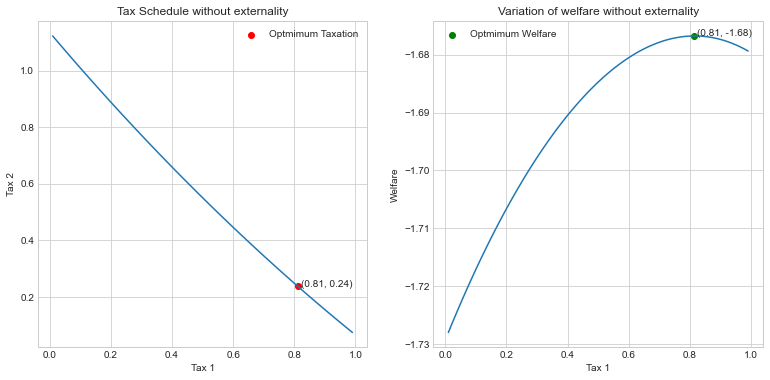

In [4]:
#Get index of the best welfare value
bestwo = np.argmax(wwo)

#Create graphs
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(13,6))
ax1.plot(l1, t2wo) ; ax2.plot(l1, wwo)
ax1.scatter(l1[bestwo], t2wo[bestwo], color = 'red', label = "Optmimum Taxation") 
ax2.scatter(l1[bestwo], wwo[bestwo], color = 'green', label = "Optmimum Welfare") 
ax1.set_title('Tax Schedule without externality') ; ax2.set_title('Variation of welfare without externality')
ax1.set_xlabel('Tax 1') ; ax1.set_ylabel('Tax 2') ; ax2.set_xlabel('Tax 1') ; ax2.set_ylabel('Welfare')

ax1.text(l1[bestwo]+0.01, t2wo[bestwo], '({}, {})'.format(np.round(l1[bestwo],2), np.round(t2wo[bestwo],2)))
ax2.text(l1[bestwo]+0.01, wwo[bestwo], '({}, {})'.format(np.round(l1[bestwo],2), np.round(wwo[bestwo],2)))  

ax1.legend() ; ax2.legend() ; plt.show()


#### Part B: Externality from Firm 1 on Welfare

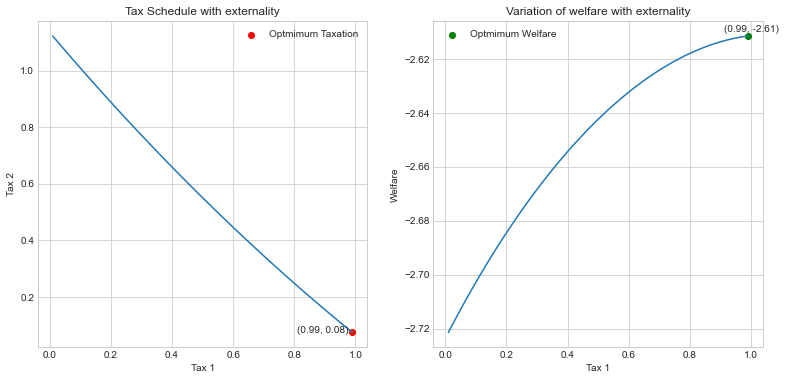

In [5]:
#Get index of the best welfare value
bestw = np.argmax(ww)

#Create graphs
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(13,6))
ax1.plot(l1, t2w) ; ax2.plot(l1, ww)
ax1.scatter(l1[bestw], t2w[bestw], color = 'red', label = "Optmimum Taxation") 
ax2.scatter(l1[bestw], ww[bestw], color = 'green', label = "Optmimum Welfare") 
ax1.set_title('Tax Schedule with externality') ; ax2.set_title('Variation of welfare with externality')
ax1.set_xlabel('Tax 1') ; ax1.set_ylabel('Tax 2') ; ax2.set_xlabel('Tax 1') ; ax2.set_ylabel('Welfare')

ax1.text(l1[bestw] - 0.18, t2w[bestw], '({}, {})'.format(np.round(l1[bestw],2), np.round(t2w[bestw],2)))
ax2.text(l1[bestw] - 0.08, ww[bestw] + 0.0015, '({}, {})'.format(np.round(l1[bestw],2), np.round(ww[bestw],2)))  

ax1.legend() ; ax2.legend() ; plt.show()

### Additional Graphs

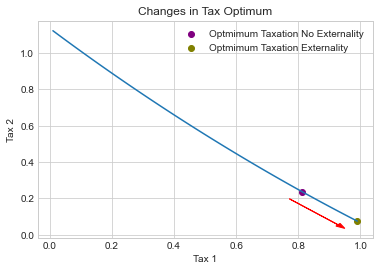

In [6]:
# Create a graph to compute how the optimal taxation combination changes due to externality
plt.plot(l1, t2w) ; a = 0.04
plt.scatter(l1[bestwo], t2wo[bestwo], color = 'purple', label = "Optmimum Taxation No Externality") 
plt.scatter(l1[bestw], t2w[bestw], color = 'olive', label = "Optmimum Taxation Externality") 
plt.arrow(l1[bestwo] - a, t2wo[bestwo] - a, l1[bestw] - l1[bestwo], - t2wo[bestwo] + t2w[bestw], shape = 'full', length_includes_head= True, head_width = 0.02, color = 'red')
plt.title("Changes in Tax Optimum") ; plt.xlabel("Tax 1") ; plt.ylabel("Tax 2")
plt.legend() ; plt.show()

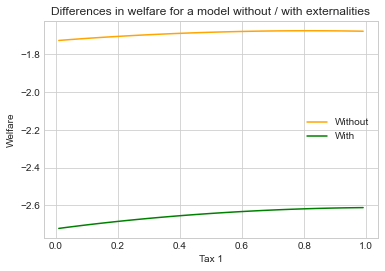

In [17]:
# Plot the 2 welfare function to compare their utility level
plt.plot(l1,wwo, color = 'orange',label = 'Without')
plt.plot(l1,ww, color = 'green',label = 'With')
plt.xlabel("Tax 1") ; plt.ylabel("Welfare")
plt.title("Differences in welfare for a model without / with externalities")
plt.legend() ; plt.show()

### Outputs analysis and comparaison

The following sell is going to display several results computed in the first scenario, which is without externalities.

In [14]:
c1 = model.divide_outputs(outwo)[0] ; c2 = model.divide_outputs(outwo)[1]
p1 = model.divide_outputs(outwo)[4] ; p2 = model.divide_outputs(outwo)[5]
bwo = np.argmax(wwo)

print("----------------------------------------------------------------")
print("Optimal tax 1 without externality :", np.round(l1[bwo],2))
print("Optimal tax 2 without externality :",np.round(t2wo[bwo],2))
print("----------------------------------------------------------------")
print("Optimal quantity 1 without externality :", np.round(c1[bwo],2))
print("Optimal quantity 2 without externality :", np.round(c2[bwo],2))
print("----------------------------------------------------------------")
print("Optimal price 1 without externality :", np.round(p1[bwo],2))
print("Optimal price 2 without externality :", np.round(p2[bwo],2))
print("----------------------------------------------------------------")
print("Relative term 1 without externality :", np.round(l1[bwo]/p1[bwo],2))
print("Relative term 2 without externality :", np.round(t2wo[bwo]/p2[bwo],2))
print("----------------------------------------------------------------")
print("Pigou term 1 without externality :", np.round(l1[bwo]/c1[bwo],2))
print("Pigou term 2 without externality :", np.round(t2wo[bwo]/c2[bwo],2))
print("----------------------------------------------------------------")
print("Tax Revenue 1 without externality :", np.round(l1[bwo]*c1[bwo],2))
print("Tax Revenue 2 without externality :", np.round(t2wo[bwo]*c2[bwo],2))
print("----------------------------------------------------------------")
print("Relative Tax Rate Ratio without externality :", np.round((l1[bwo]/ p1[bwo])/(t2wo[bwo]/p2[bwo]),2))
print("----------------------------------------------------------------")


----------------------------------------------------------------
Optimal tax 1 without externality : 0.81
Optimal tax 2 without externality : 0.24
----------------------------------------------------------------
Optimal quantity 1 without externality : 0.94
Optimal quantity 2 without externality : 1.0
----------------------------------------------------------------
Optimal price 1 without externality : 1.03
Optimal price 2 without externality : 0.79
----------------------------------------------------------------
Relative term 1 without externality : 0.79
Relative term 2 without externality : 0.3
----------------------------------------------------------------
Pigou term 1 without externality : 0.86
Pigou term 2 without externality : 0.24
----------------------------------------------------------------
Tax Revenue 1 without externality : 0.76
Tax Revenue 2 without externality : 0.24
----------------------------------------------------------------
Relative Tax Rate Ratio without externa

Outcomes in the presence of the externality.

In [15]:
c1e = model.divide_outputs(outw)[0] ; c2e = model.divide_outputs(outw)[1]
p1e = model.divide_outputs(outw)[4] ; p2e = model.divide_outputs(outw)[5]

bw = np.argmax(ww) 

print("----------------------------------------------------------------")
print("Optimal tax 1 with externality :", np.round(l1[bw],2))
print("Optimal tax 2 with externality :", np.round(t2w[bw],2))

print("----------------------------------------------------------------")
print("Optimal quantity 1 with externality :", np.round(c1e[bw],2))
print("Optimal quantity 2 with externality :", np.round(c2e[bw],2))

print("----------------------------------------------------------------")
print("Optimal price 1 with externality :", np.round(p1e[bw],2))
print("Optimal price 2 with externality :", np.round(p2e[bw],2))

print("----------------------------------------------------------------")
print("Relative term 1 with externality :", np.round(l1[bw]/ p1e[bw],2))
print("Relative term 2 with externality :", np.round(t2w[bw]/p2e[bw],2))

print("----------------------------------------------------------------")
print("Pigou term 1 with externality :", np.round(l1[bw]/ c1e[bw],2))
print("Pigou term 2 with externality :", np.round(t2w[bw]/c2e[bw],2))

print("----------------------------------------------------------------")
print("Tax Revenue 1 with externality :", np.round(l1[bw]*c1e[bw],2))
print("Tax Revenue 2 with externality :", np.round(t2w[bw]*c2e[bw],2))

print("----------------------------------------------------------------")
print("Relative Tax Rate Ratio with externality :", np.round((l1[bw]/ p1e[bw])/(t2w[bw]/p2e[bw]),2))
print("----------------------------------------------------------------")

----------------------------------------------------------------
Optimal tax 1 with externality : 0.99
Optimal tax 2 with externality : 0.08
----------------------------------------------------------------
Optimal quantity 1 with externality : 0.93
Optimal quantity 2 with externality : 1.03
----------------------------------------------------------------
Optimal price 1 with externality : 1.03
Optimal price 2 with externality : 0.8
----------------------------------------------------------------
Relative term 1 with externality : 0.96
Relative term 2 with externality : 0.09
----------------------------------------------------------------
Pigou term 1 with externality : 1.06
Pigou term 2 with externality : 0.07
----------------------------------------------------------------
Tax Revenue 1 with externality : 0.92
Tax Revenue 2 with externality : 0.08
----------------------------------------------------------------
Relative Tax Rate Ratio with externality : 10.21
-------------------------

Differences in coutcomes between models with and without externalities.

In [16]:
print("----------------------------------------------------------------") 
print("Changes in taxes good 1 due to the externality :", np.round(l1[bw] - l1[bwo],2))
print("Changes in taxes good 2 due to the externality :", np.round(t2w[bw] - t2wo[bwo],2))
print("----------------------------------------------------------------") 
print("Changes in quantity good 1 due to the externality :", np.round(c1e[bw] - c1[bwo],2))
print("Changes in quantity good 2 due to the externality :", np.round(c2e[bw] - c2[bwo],2))
print("----------------------------------------------------------------") 
print("Changes in prices good 1 due to the externality :", np.round(p1e[bw] - p1[bwo],2))
print("Changes in prices good 2 due to the externality :", np.round(p2e[bw] - p2[bwo],2))

----------------------------------------------------------------
Changes in taxes good 1 due to the externality : 0.18
Changes in taxes good 2 due to the externality : -0.16
----------------------------------------------------------------
Changes in quantity good 1 due to the externality : -0.01
Changes in quantity good 2 due to the externality : 0.03
----------------------------------------------------------------
Changes in prices good 1 due to the externality : -0.0
Changes in prices good 2 due to the externality : 0.01


--------